<a href="https://colab.research.google.com/github/jieun0441/XMC/blob/main/XMC_Fig4(a)_quadrant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

# 1. 구글 드라이브 마운트가 잘 되었는지 확인
if not os.path.exists('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')

# 2. 'FMC_Data' 폴더가 있는지 확인 (상위 폴더부터 차근차근)
print("Checking path: /content/drive/MyDrive/FMC_Data")
if os.path.exists('/content/drive/MyDrive/FMC_Data'):
    print(" -> Found!")
    print("Listing files in 'FMC_Data':")
    print(os.listdir('/content/drive/MyDrive/FMC_Data'))
else:
    print(" -> NOT Found. Please check if the folder name is correct.")
    # MyDrive 바로 아래 파일들 목록을 출력해서 혹시 이름이 다른지 확인
    print("\nListing folders in '/content/drive/MyDrive' (Top 20):")
    try:
        print(os.listdir('/content/drive/MyDrive')[:20])
    except:
        print("Cannot list MyDrive.")

Mounted at /content/drive
Checking path: /content/drive/MyDrive/FMC_Data
 -> Found!
Listing files in 'FMC_Data':
['LOCAL_PEOPLE_DONG_202303', 'LOCAL_PEOPLE_GU_2023', 'M_B_Aggregated', 'M_B_dong_Aggregated_noNan', 'ADMI_202303.csv', 'Eng_name_of_Korean_districts', 'Income_variable', 'Population_variable', 'matched_Seoul_dong_y_and_Xvariables.xlsx', 'matched_Seoul_dong_y_and_Xvariables_with_different time zone de facto populations.xlsx', 'matched_Seoul_dong_y_and_Xvariables_with24567.xlsx', 'M_B_how_much_less_Xmin', 'Calculation_cnt_within15min_Seoul_residents_ver2.xlsx', 'Calculation_cnt_within15min_SeoulMetropolitan_residents.xlsx', 'Calculation_cnt_within_distance_Seoul_residents_ver2.xlsx', 'Calculation_cnt_within_distance_SMA_residents_ver2.xlsx', 'Copy of Calculation_cnt_within_distance_SMA_residents_ver2.xlsx', 'Analysis_Ln T Ln Amt and Ln Defacto.xlsx', 'matched_Seoul_dong_y_and_Xvariables_with_different time zone de facto populations_24567.xlsx', 'matched_Seoul_dong_y_and_Xvaria

In [ ]:
import os
import numpy as np
import pandas as pd

# ==========================================
# 1. Configuration & File Paths
# ==========================================
# Update this directory if necessary
data_dir = "/content/drive/MyDrive/FMC_Data/Sharing_to_Public"

pop_file = os.path.join(data_dir, "population_Seoul_426dong_2023.xlsx")
nw_file  = os.path.join(data_dir, "Tij_NonworkTrips_P24567_in2023.xlsx")
w_file   = os.path.join(data_dir, "Tij_P1_Going_to_Work_in2023.xlsx")

# ==========================================
# 2. Load Population Data (Cell 1 Logic)
# ==========================================
print("Loading population data...")
df_pop = pd.read_excel(pop_file, sheet_name="Sheet1", engine="openpyxl")

# Standardize columns
df_pop = df_pop.rename(columns={
    "dong_cd": "dong_cd",
    "household": "household",
    "regist_pop": "regist_pop",
    "defacto_pop": "defacto_pop"
})
df_pop["dong_cd"] = df_pop["dong_cd"].astype(str)

# Extract dong_ids to ensure consistent ordering
dong_ids = df_pop["dong_cd"].tolist()
print(f"Loaded {len(dong_ids)} dongs.")

# ==========================================
# 3. Load Trip Data (Cell 3a Logic)
# ==========================================
print("Loading trip data (this might take a moment)...")
usecols_t = ["O_ADMDONG_CD", "D_ADMDONG_CD", "CNT"]
df_T_nw = pd.read_excel(nw_file, usecols=usecols_t, engine="openpyxl")
df_T_w  = pd.read_excel(w_file , usecols=usecols_t, engine="openpyxl")

# Clean types
for dfT in (df_T_nw, df_T_w):
    dfT["O_ADMDONG_CD"] = dfT["O_ADMDONG_CD"].astype(str)
    dfT["D_ADMDONG_CD"] = dfT["D_ADMDONG_CD"].astype(str)
    dfT["CNT"] = pd.to_numeric(dfT["CNT"], errors="coerce").fillna(0.0)

# ==========================================
# 4. Build Matrices & Compute Indices (Cell 3b Logic)
# ==========================================
def build_dense_T(dfT, dong_ids):
    """Return dense matrix T (n x n) in order of dong_ids."""
    idx_map = {d: i for i, d in enumerate(dong_ids)}
    n = len(dong_ids)
    T = np.zeros((n, n), dtype=float)
    # Fast grouping and filling
    for (o, d), cnt in dfT.groupby(["O_ADMDONG_CD", "D_ADMDONG_CD"])["CNT"].sum().items():
        i = idx_map.get(o)
        j = idx_map.get(d)
        if i is not None and j is not None:
            T[i, j] = float(cnt)
    return T

print("Building dense matrices...")
T_nw = build_dense_T(df_T_nw, dong_ids)
T_w  = build_dense_T(df_T_w , dong_ids)

def compute_SC(T):
    """SC(i) = T_ii / sum_j T_ij"""
    OT = T.sum(axis=1)  # outgoing
    diag = np.diag(T)
    with np.errstate(divide="ignore", invalid="ignore"):
        SC = np.where(OT > 0, diag / OT, 0.0)
    return SC, OT

def compute_PE(T):
    """PE(i) = sum_j T_ji / sum_{m,n} T_{mn}"""
    total = T.sum()
    IT = T.sum(axis=0)  # incoming per destination i
    with np.errstate(divide="ignore", invalid="ignore"):
        PE = np.where(total > 0, IT / total, 0.0)
    return PE, IT, total

print("Computing SC and PE indices...")
SC_nw, OT_nw = compute_SC(T_nw)
SC_w , OT_w  = compute_SC(T_w )
PE_nw, IT_nw, total_nw = compute_PE(T_nw)
PE_w , IT_w , total_w  = compute_PE(T_w )

# ==========================================
# 5. Create df_SC_PE and pop_ordered
# ==========================================
df_SC_PE = pd.DataFrame({
    "dong_cd": dong_ids,
    "SC_nw": SC_nw,
    "SC_w": SC_w,
    "PE_nw": PE_nw,
    "PE_w": PE_w,
    "OT_nw": OT_nw,
    "IT_nw": IT_nw,
    "OT_w": OT_w,
    "IT_w": IT_w
})

# Merge de facto population for weighting
df_SC_PE = df_SC_PE.merge(
    df_pop[["dong_cd", "defacto_pop"]],
    on="dong_cd", how="left"
)

# Create the population array for weighting
pop_ordered = df_SC_PE["defacto_pop"].astype(float).to_numpy()
pop_ordered = np.where(np.isfinite(pop_ordered) & (pop_ordered > 0), pop_ordered, 0.0)

print("Done! 'df_SC_PE' and 'pop_ordered' are ready.")

Loading population data...
Loaded 426 dongs.
Loading trip data (this might take a moment)...
Building dense matrices...
Computing SC and PE indices...
Done! 'df_SC_PE' and 'pop_ordered' are ready.


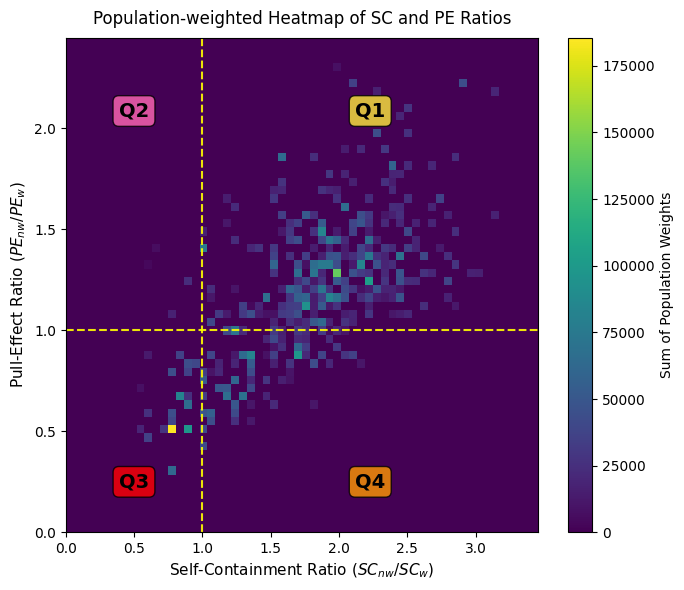

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. Data Preparation (Extracted from your snippet)
# ==========================================
# Ensure we are using the arrays from your previous cells
SC_nw = df_SC_PE["SC_nw"].to_numpy(float)
SC_w  = df_SC_PE["SC_w" ].to_numpy(float)
PE_nw = df_SC_PE["PE_nw"].to_numpy(float)
PE_w  = df_SC_PE["PE_w" ].to_numpy(float)
w_pop = np.asarray(pop_ordered, float)

# Filter valid data (finite and positive denominators)
mask_base = (
    np.isfinite(SC_nw) & np.isfinite(SC_w) & (SC_w > 0) &
    np.isfinite(PE_nw) & np.isfinite(PE_w) & (PE_w > 0) &
    np.isfinite(w_pop) & (w_pop >= 0)
)

# Calculate Ratios
x_ratio_all = np.divide(SC_nw, SC_w, out=np.full_like(SC_nw, np.nan), where=(SC_w > 0))
y_ratio_all = np.divide(PE_nw, PE_w, out=np.full_like(PE_w, np.nan), where=(PE_w > 0))

# Apply mask
mask_pos = mask_base & (x_ratio_all > 0) & (y_ratio_all > 0)
xv = x_ratio_all[mask_pos]
yv = y_ratio_all[mask_pos]
wv = w_pop[mask_pos]

if xv.size == 0:
    raise ValueError("No valid data points found for plotting.")

# ==========================================
# 2. Plotting Configuration
# ==========================================
# Set plot limits (same logic as your code: 99.5 percentile + buffer)
qx = float(np.nanquantile(xv, 0.995))
qy = float(np.nanquantile(yv, 0.995))
xmax = min(5.0, max(2.0, 1.10 * qx))
ymax = min(5.0, max(2.0, 1.10 * qy))

# Define bins for 2D histogram
bins_2d = 60
xedges = np.linspace(0.0, xmax, bins_2d + 1)
yedges = np.linspace(0.0, ymax, bins_2d + 1)

# Compute Weighted 2D Histogram
H_wgt, _, _ = np.histogram2d(xv, yv, bins=[xedges, yedges], weights=wv)

# ==========================================
# 3. Figure Generation
# ==========================================
fig, ax = plt.subplots(figsize=(7, 6)) # Size adjusted for publication

# Plot Heatmap
# Using Transpose (H_wgt.T) because histogram2d returns (x,y) but pcolormesh expects (row,col)
im = ax.pcolormesh(xedges, yedges, H_wgt.T, cmap='viridis', shading='auto')

# Add Quadrant Dividers (Yellow Dashed Lines)
ax.axvline(1.0, linestyle="--", color="yellow", linewidth=1.5, alpha=0.9)
ax.axhline(1.0, linestyle="--", color="yellow", linewidth=1.5, alpha=0.9)


# ==========================================
# 4. Add Quadrant Labels (Colors matched to Map)
# ==========================================
# QGIS에서 선택한 색상 테마 적용
# 글자색은 검정(Black)으로 하고, 배경 박스 색상을 각 유형에 맞게 변경합니다.

# 공통 스타일 (글자는 검정색, 굵게)
text_style = dict(fontsize=14, fontweight='bold', color='black', ha='center', va='center')

# 각 사분면별 배경 박스 색상 (QGIS 색상과 매칭)
# alpha=0.7로 설정하여 뒤의 히트맵이 살짝 비치면서도 색상은 명확하게
bbox_q1 = dict(facecolor='#FFEB3B', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.3') # Q1: 연한 노랑 (Yellow)
bbox_q2 = dict(facecolor='#FF69B4', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.3') # Q2: 분홍 (Hot Pink)
bbox_q3 = dict(facecolor='#FF0000', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.3') # Q3: 빨강 (Red)
bbox_q4 = dict(facecolor='#FF9800', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.3') # Q4: 주황 (Orange)

# 라벨 추가

# ---  위치 조정 로직 ---
# Q3, Q4 (아래쪽): 0.5보다 더 아래인 0.25 지점으로 이동
y_bottom = 0.25

# Q1, Q2 (위쪽): 1.0을 넘어서는 영역(ymax-1.0)의 75% 지점까지 위로 이동 (기존은 50%)
y_top = 1.0 + (ymax - 1.0) * 0.75

# 라벨 배치
# Q3: Working Hubs (Red) - Bottom Left
ax.text(0.5, y_bottom, "Q3", **text_style, bbox=bbox_q3)

# Q4: Mixed-use (Orange) - Bottom Right
ax.text(1.0 + (xmax-1.0)/2, y_bottom, "Q4", **text_style, bbox=bbox_q4)

# Q2: Leisure Hotspots (Pink) - Top Left
ax.text(0.5, y_top, "Q2", **text_style, bbox=bbox_q2)

# Q1: Residential Nodes (Yellow) - Top Right
ax.text(1.0 + (xmax-1.0)/2, y_top, "Q1", **text_style, bbox=bbox_q1)


# ==========================================
# 5. Final Formatting
# ==========================================
ax.set_xlim(0, xmax)
ax.set_ylim(0, ymax)

# Labels with LaTeX formatting
ax.set_xlabel(r"Self-Containment Ratio ($SC_{nw} / SC_{w}$)", fontsize=11)
ax.set_ylabel(r"Pull-Effect Ratio ($PE_{nw} / PE_{w}$)", fontsize=11)
ax.set_title("Population-weighted Heatmap of SC and PE Ratios", fontsize=12, pad=10)

# Colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Sum of Population Weights", fontsize=10)

plt.tight_layout()

# Save the figure
plt.savefig('Figure4_a_Heatmap_labeled_colorchanged.png', dpi=300, bbox_inches='tight')
plt.savefig('Figure4_a_Heatmap_labeled_colorchanged.pdf', bbox_inches='tight') # Vector format
plt.show()

이미지가 (a) 라벨과 함께 다시 저장되었습니다.


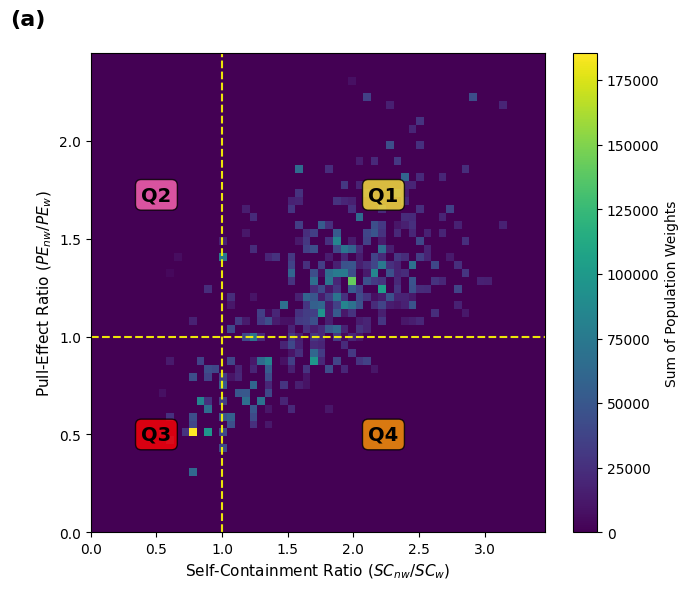

In [ ]:
import matplotlib.pyplot as plt
# import numpy as np

# ==========================================
# 1. Data Preparation (Assuming data is loaded)
# ==========================================
SC_nw = df_SC_PE["SC_nw"].to_numpy(float)
SC_w  = df_SC_PE["SC_w" ].to_numpy(float)
PE_nw = df_SC_PE["PE_nw"].to_numpy(float)
PE_w  = df_SC_PE["PE_w" ].to_numpy(float)
w_pop = np.asarray(pop_ordered, float)

mask_base = (
    np.isfinite(SC_nw) & np.isfinite(SC_w) & (SC_w > 0) &
    np.isfinite(PE_nw) & np.isfinite(PE_w) & (PE_w > 0) &
    np.isfinite(w_pop) & (w_pop >= 0)
)

x_ratio_all = np.divide(SC_nw, SC_w, out=np.full_like(SC_nw, np.nan), where=(SC_w > 0))
y_ratio_all = np.divide(PE_nw, PE_w, out=np.full_like(PE_w, np.nan), where=(PE_w > 0))

mask_pos = mask_base & (x_ratio_all > 0) & (y_ratio_all > 0)
xv = x_ratio_all[mask_pos]
yv = y_ratio_all[mask_pos]
wv = w_pop[mask_pos]

if xv.size == 0:
    raise ValueError("No valid data points found for plotting.")

# ==========================================
# 2. Plotting Configuration
# ==========================================
qx = float(np.nanquantile(xv, 0.995))
qy = float(np.nanquantile(yv, 0.995))
xmax = min(5.0, max(2.0, 1.10 * qx))
ymax = min(5.0, max(2.0, 1.10 * qy))

bins_2d = 60
xedges = np.linspace(0.0, xmax, bins_2d + 1)
yedges = np.linspace(0.0, ymax, bins_2d + 1)

H_wgt, _, _ = np.histogram2d(xv, yv, bins=[xedges, yedges], weights=wv)

# ==========================================
# 3. Figure Generation
# ==========================================
fig, ax = plt.subplots(figsize=(7, 6))

im = ax.pcolormesh(xedges, yedges, H_wgt.T, cmap='viridis', shading='auto')

ax.axvline(1.0, linestyle="--", color="yellow", linewidth=1.5, alpha=0.9)
ax.axhline(1.0, linestyle="--", color="yellow", linewidth=1.5, alpha=0.9)

# ==========================================
# [수정된 부분] 4. Add Quadrant Labels (Colors matched to Map)
# ==========================================
# QGIS에서 선택한 색상 테마 적용
# 글자색은 검정(Black)으로 하고, 배경 박스 색상을 각 유형에 맞게 변경합니다.

# 공통 스타일 (글자는 검정색, 굵게)
text_style = dict(fontsize=14, fontweight='bold', color='black', ha='center', va='center')

# 각 사분면별 배경 박스 색상 (QGIS 색상과 매칭)
# alpha=0.7로 설정하여 뒤의 히트맵이 살짝 비치면서도 색상은 명확하게
bbox_q1 = dict(facecolor='#FFEB3B', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.3') # Q1: 연한 노랑 (Yellow)
bbox_q2 = dict(facecolor='#FF69B4', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.3') # Q2: 분홍 (Hot Pink)
bbox_q3 = dict(facecolor='#FF0000', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.3') # Q3: 빨강 (Red)
bbox_q4 = dict(facecolor='#FF9800', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.3') # Q4: 주황 (Orange)

# 라벨 추가 (위치 로직은 그대로)
# Q3: Working Hubs (Red) - Bottom Left
ax.text(0.5, 0.5, "Q3", **text_style, bbox=bbox_q3)

# Q4: Mixed-use (Orange) - Bottom Right
ax.text(1.0 + (xmax-1.0)/2, 0.5, "Q4", **text_style, bbox=bbox_q4)

# Q2: Leisure Hotspots (Pink) - Top Left
ax.text(0.5, 1.0 + (ymax-1.0)/2, "Q2", **text_style, bbox=bbox_q2)

# Q1: Residential Nodes (Yellow) - Top Right
ax.text(1.0 + (xmax-1.0)/2, 1.0 + (ymax-1.0)/2, "Q1", **text_style, bbox=bbox_q1)

# ==========================================
# 5. Final Formatting
# ==========================================
ax.set_xlim(0, xmax)
ax.set_ylim(0, ymax)

ax.set_xlabel(r"Self-Containment Ratio ($SC_{nw} / SC_{w}$)", fontsize=11)
ax.set_ylabel(r"Pull-Effect Ratio ($PE_{nw} / PE_{w}$)", fontsize=11)
# 제목은 논문 패널에서는 보통 빼지만, 일단 유지했습니다. 필요하면 주석처리하세요.
# ax.set_title("Population-weighted Heatmap of SC and PE Ratios", fontsize=12, pad=10)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Sum of Population Weights", fontsize=10)

# ==========================================
# 6. Add Panel Label (a) [NEW]
# ==========================================
# transform=ax.transAxes를 사용하여 데이터 좌표가 아닌 축 비율(0~1)로 위치 지정
# (-0.1, 1.05) 위치는 그래프 왼쪽 상단 바깥쪽을 의미합니다.
ax.text(-0.1, 1.05, '(a)', transform=ax.transAxes,
        fontsize=16, fontweight='bold', va='bottom', ha='right', color='black')


plt.tight_layout()

# Save the figure (덮어쓰기 됩니다)
plt.savefig('Figure4_a_Heatmap_labeled.png', dpi=300, bbox_inches='tight')
plt.savefig('Figure4_a_Heatmap_labeled.pdf', bbox_inches='tight')
print("이미지가 (a) 라벨과 함께 다시 저장되었습니다.")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import os

# ==========================================
# 1. 4분면(Quadrant) 정보 다시 계산
# ==========================================
# (이미 df_SC_PE, pop_ordered 등이 로드되어 있다고 가정합니다)
SC_nw = df_SC_PE["SC_nw"].to_numpy(float)
SC_w  = df_SC_PE["SC_w" ].to_numpy(float)
PE_nw = df_SC_PE["PE_nw"].to_numpy(float)
PE_w  = df_SC_PE["PE_w" ].to_numpy(float)
w_pop = np.asarray(pop_ordered, float)

# 유효 데이터 마스크
mask_base = (
    np.isfinite(SC_nw) & np.isfinite(SC_w) & (SC_w > 0) &
    np.isfinite(PE_nw) & np.isfinite(PE_w) & (PE_w > 0) &
    np.isfinite(w_pop) & (w_pop >= 0)
)
x_ratio_all = np.divide(SC_nw, SC_w, out=np.full_like(SC_nw, np.nan), where=(SC_w > 0))
y_ratio_all = np.divide(PE_nw, PE_w, out=np.full_like(PE_w, np.nan), where=(PE_w > 0))

# 4분면 결정 함수
def _quad(x, y):
    if (x > 1) and (y > 1): return "Q1"
    if (x < 1) and (y > 1): return "Q2"
    if (x < 1) and (y < 1): return "Q3"
    if (x > 1) and (y < 1): return "Q4"
    return "On lines"

# df_rat 생성 (동코드, 비율, 4분면 정보)
df_rat = pd.DataFrame({
    "dong_cd": np.array(dong_ids),
    "x_ratio": x_ratio_all,
    "y_ratio": y_ratio_all
})

# 유효한 데이터만 남기고 4분면 라벨링
mask_pos = mask_base & (x_ratio_all > 0) & (y_ratio_all > 0)
df_rat = df_rat.loc[mask_pos, :].copy()
df_rat["quadrant"] = [_quad(a, b) for a, b in zip(df_rat["x_ratio"], df_rat["y_ratio"])]

# ==========================================
# 2. df_map 생성 (단순히 df_rat만 있어도 QGIS 작업 가능)
# ==========================================
# 굳이 좌표(centroid) 파일까지 다시 로드할 필요 없이,
# 행정동 코드(dong_cd)와 4분면 정보(quadrant)만 있으면 QGIS에서 Shapefile과 조인할 수 있습니다.
df_map = df_rat.copy()

# ==========================================
# 3. CSV 파일로 내보내기
# ==========================================
output_csv = "Seoul_Quadrant_Classification_for_QGIS.csv"
df_map[['dong_cd', 'quadrant', 'x_ratio', 'y_ratio']].to_csv(output_csv, index=False, encoding='utf-8-sig')

print(f"파일이 저장되었습니다: {output_csv}")
print("df_map 변수도 생성되었습니다.")

파일이 저장되었습니다: Seoul_Quadrant_Classification_for_QGIS.csv
df_map 변수도 생성되었습니다.
